# Model Training with fine-tuning

In [ ]:
# import all packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Add, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
feature_path='.../test_spectra_sheet_raw.csv'
tbl = pd.read_csv(feature_path)
tbl = tbl.set_index('ID')
print(tbl.shape)

feature_path2='.../test_spectra_sheet_denoised.csv'
tbl2 = pd.read_csv(feature_path2)
tbl2 = tbl2.set_index('ID')
print(tbl2.shape)

(6604, 3815)
(6604, 3815)


In [ ]:
tbl.head(5)

,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
ID,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,0,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,3,0,1,3,1,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,2,2,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,1,1,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:9116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


(3815, 1)

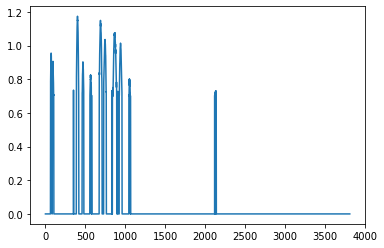

In [ ]:
def read_features(ID, desired_size = (3815,1), alpha = 0.5):
    try:    

        if alpha < 0.3:
            row = tbl2.loc[ID,:]
            row[row < 3] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)            
        else:  
            row = tbl.loc[ID,:]
            row[row < 3] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)
    except:
        row = np.zeros(desired_size)        
    return row

a = read_features(30, (3815,1), 0.2)
plt.plot(a)
a.shape

In [ ]:
gt_path='.../test_label_13.csv'
gt = pd.read_csv(gt_path)
gt = gt.set_index('ID')
gt.shape

(6604, 13)

In [ ]:
def read_gt(ID, desired_size = (13,1)):
    try:
        row = gt.loc[ID,:]
#         row = np.expand_dim(row, axis = -1)
    except:
        row = np.zeros(desired_size)  
    
    return row
a = read_gt(3000, (13,1))
a.shape

(13,)

In [ ]:
a

Cadmium yellow      0
Chromate yellow     0
Chromate green      1
Cobalt blue         1
Emerald green       0
Iron oxide          0
Lead White          1
Prussian blue       0
Red lead            0
SnO2                0
Ultramarine blue    0
Vermilion           1
ZnO                 1
Name: 3000, dtype: int64

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=64, dim=tbl.shape[1], n_channels=1,
                     augment =False, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels))
        y = np.empty((self.batch_size, 13), dtype=np.float32)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.augment:
                alpha = np.random.uniform(0,1)
            else:
                alpha = 0.5
            XXX = read_features(ID, alpha=alpha)
            X[i,] = XXX

            y[i,] = read_gt(ID)

        return X, y

In [ ]:
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation = 'relu',input_shape=(tbl.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation="sigmoid", name='dense_output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3811, 64)          384       
_________________________________________________________________
batch_normalization (BatchNo (None, 3811, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1905, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1903, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1903, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 951, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 949, 64)           1

In [ ]:
model.load_weights('.../model/model_deeper_bg_13.hdf5')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tbl, gt, test_size=0.80, random_state=42)
print(X_train.shape, X_test.shape)

(1320, 3815) (5284, 3815)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(X_train.shape, X_valid.shape)

(1056, 3815) (264, 3815)


In [ ]:
train_generator  = DataGenerator(X_train.index, 64, X_train.shape[1], 1, augment =True, shuffle=True)
valid_generator = DataGenerator(X_valid.index, 64, X_valid.shape[1], 1, shuffle=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', 
                   verbose=1, 
                   patience=10, 
                   min_delta=0.00001, 
                   mode='max')
mc = ModelCheckpoint('.../model/model_deeper_finetune_small_13.hdf5', 
                     monitor='val_accuracy', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max')
rlr = ReduceLROnPlateau(monitor='val_accuracy',
                        mode='max',
                        factor=0.1,
                        patience=10)

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
history =model.fit_generator(train_generator, epochs=100,verbose=1, max_queue_size=1, 
                               workers=1, validation_data=valid_generator,
                                callbacks = [es, mc,rlr],use_multiprocessing=False)

Epoch 1/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5044 - accuracy: 0.7954
Epoch 00001: val_accuracy improved from -inf to 0.85006, saving model to /home/yunan/Pigment/model/model_deeper_finetune_small_13.hdf5
16/16 [==============================] - 10s 644ms/step - loss: 0.4965 - accuracy: 0.7991 - val_loss: 0.3817 - val_accuracy: 0.8501
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8681
Epoch 00002: val_accuracy improved from 0.85006 to 0.86719, saving model to /home/yunan/Pigment/model/model_deeper_finetune_small_13.hdf5
16/16 [==============================] - 9s 566ms/step - loss: 0.3067 - accuracy: 0.8691 - val_loss: 0.3427 - val_accuracy: 0.8672
Epoch 3/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2527 - accuracy: 0.8865
Epoch 00003: val_accuracy improved from 0.86719 to 0.87770, saving model to /home/yunan/Pigment/model/model_deeper_finetune_small_13.hdf5
16/16 [==============================] - 

Epoch 26/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0776 - accuracy: 0.9742
Epoch 00026: val_accuracy did not improve from 0.92097
16/16 [==============================] - 10s 616ms/step - loss: 0.0778 - accuracy: 0.9739 - val_loss: 0.2017 - val_accuracy: 0.9180
Epoch 27/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9744
Epoch 00027: val_accuracy did not improve from 0.92097
16/16 [==============================] - 8s 502ms/step - loss: 0.0758 - accuracy: 0.9747 - val_loss: 0.2033 - val_accuracy: 0.9168
Epoch 28/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0767 - accuracy: 0.9750
Epoch 00028: val_accuracy did not improve from 0.92097
16/16 [==============================] - 8s 503ms/step - loss: 0.0765 - accuracy: 0.9750 - val_loss: 0.2054 - val_accuracy: 0.9141
Epoch 29/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0722 - accuracy: 0.9777
Epoch 00029: val_accuracy did not improve from 0.92097
16

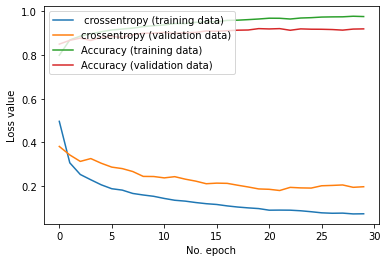

In [ ]:
# Plot history: Categorical crossentropy & Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label=' crossentropy (training data)')
plt.plot(history.history['val_loss'], label='crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
# plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

# Validation

In [ ]:
model.load_weights('.../model/model_deeper_finetune_small_13.hdf5')

In [ ]:
valid_generator = DataGenerator(X_valid.index, 1, X_valid.shape[1], 1, shuffle=False)
r = model.predict_generator(valid_generator)

In [ ]:
result = (r>0.5)*1.0                     
result.shape

(264, 11)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(y_valid['Chromate'], result[:,-2]))

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.67      0.67        66
           1       0.89      0.89      0.89       198

    accuracy                           0.84       264
   macro avg       0.78      0.78      0.78       264
weighted avg       0.84      0.84      0.84       264



In [ ]:
classes = y_valid.columns
classes.shape

(13,)

In [ ]:
Acc = []
pre = []
f1 = []
recall = []

In [1]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

for i in range(13):
    ex = classes[i]
    print('{}_acc: {}'.format(ex, accuracy_score(result[:,i], y_valid[classes[i]])))
    Acc.append( accuracy_score(result[:,i], y_valid[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result[:,i], y_valid[classes[i]])))
    pre.append( precision_score(result[:,i], y_valid[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result[:,i], y_valid[classes[i]])))
    f1.append( f1_score(result[:,i], y_valid[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result[:,i], y_valid[classes[i]])))
    recall.append( recall_score(result[:,i], y_valid[classes[i]]))
    print(classification_report(y_valid[classes[i]], result[:,i]))
    print('************************************')

# Testing

In [ ]:
test_generator = DataGenerator(X_test.index, 1, X_test.shape[1], 1, shuffle=False)
r = model.predict_generator(test_generator)

In [ ]:
result = (r>0.5)*1.0                     
result.shape

(5284, 13)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
for i in range(13):
    ex = classes[i]
    print('{}_acc: {}'.format(ex, accuracy_score(result[:,i], y_test[classes[i]])))
    Acc.append( accuracy_score(result[:,i], y_test[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result[:,i], y_test[classes[i]])))
    pre.append( precision_score(result[:,i], y_test[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result[:,i], y_test[classes[i]])))
    f1.append( f1_score(result[:,i], y_test[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result[:,i], y_test[classes[i]])))
    recall.append( recall_score(result[:,i], y_test[classes[i]]))
    print(classification_report(y_test[classes[i]], result[:,i]))
    print('************************************')

Cadmium yellow_acc: 1.0
Cadmium yellow_preci: 0.0
Cadmium yellow_f1: 0.0
Cadmium yellow_recall: 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5284

    accuracy                           1.00      5284
   macro avg       1.00      1.00      1.00      5284
weighted avg       1.00      1.00      1.00      5284

************************************
Chromate yellow_acc: 0.830999242997729
Chromate yellow_preci: 0.822530329289428
Chromate yellow_f1: 0.841638588402199
Chromate yellow_recall: 0.8616557734204793
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2399
           1       0.86      0.82      0.84      2885

    accuracy                           0.83      5284
   macro avg       0.83      0.83      0.83      5284
weighted avg       0.83      0.83      0.83      5284

************************************
Chromate green_acc: 0.7976911430734293
Chromate green_preci: 0.19

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Emerald green_preci: 0.8714038128249567
Emerald green_f1: 0.8706493506493506
Emerald green_recall: 0.8698961937716263
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2399
           1       0.87      0.87      0.87      2885

    accuracy                           0.86      5284
   macro avg       0.86      0.86      0.86      5284
weighted avg       0.86      0.86      0.86      5284

************************************
Iron oxide_acc: 0.9984859954579863
Iron oxide_preci: 0.9984639016897081
Iron oxide_f1: 0.9969325153374232
Iron oxide_recall: 0.9954058192955589
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3982
           1       1.00      1.00      1.00      1302

    accuracy                           1.00      5284
   macro avg       1.00      1.00      1.00      5284
weighted avg       1.00      1.00      1.00      5284

************************************
Lead White

In [ ]:
coms = y_test.drop_duplicates()
coms

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO2,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
1483,0,1,0,0,1,1,0,1,1,0,1
4999,0,1,1,0,1,1,0,1,1,1,1
5396,0,0,1,1,0,0,0,1,1,1,0
3034,0,1,0,0,0,0,0,1,1,1,1
1084,0,0,0,0,0,0,0,1,1,0,1
1844,0,1,0,0,1,1,0,0,1,1,1
1414,0,1,0,0,0,1,0,1,1,0,1
2646,0,1,0,0,0,1,0,1,1,1,1
2846,0,1,1,1,0,0,0,1,1,1,1


In [ ]:
coms.iloc[2]

Cadmium yellow      0
Cobalt blue         0
Emerald green       1
Iron oxide          1
Prussian blue       0
SnO2                0
Ultramarine blue    0
Vermilion           1
ZnO                 1
Chromate            1
Lead                0
Name: 5396, dtype: int64

In [ ]:
exx = y_test[y_test == coms.iloc[2]].dropna()
exx

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO2,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
5396,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
5357,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
5234,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
5312,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
5361,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
4362,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
4254,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
4391,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0
5324,0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0


In [ ]:
dff = pd.DataFrame(result, columns =y_test.columns, index = y_test.index)
dff.shape
bi_pre = dff.loc[exx.index]

In [ ]:
bi_pre.drop_duplicates()

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO2,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
5396,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4362,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5383,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
5313,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [ ]:
lala = bi_pre.groupby(bi_pre.columns.tolist(),as_index=False).size()

In [ ]:
lala[0]

Cobalt blue  Emerald green  Iron oxide  Prussian blue  SnO2  Ultramarine blue  Vermilion  ZnO  Chromate  Lead
0.0          1.0            1.0         0.0            0.0   0.0               1.0        1.0  1.0       0.0     195
                                                                                                         1.0      74
1.0          1.0            1.0         0.0            0.0   0.0               1.0        1.0  1.0       0.0      12
                                                                                                         1.0      12
dtype: int64

# Visualizations

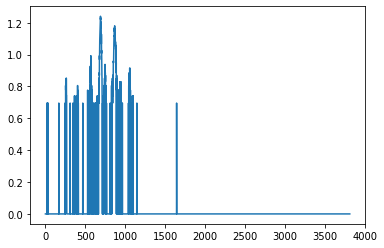

In [ ]:
IIDD = 3000

a = read_features(IIDD, (4096,1), 0.5)  # 8000
plt.plot(a)
a.shape
a = np.expand_dims(a, axis = 0)

In [ ]:
res_a = model.predict(a)

In [ ]:
res_a

array([[1.1980534e-05, 8.5880613e-01, 1.9829768e-01, 1.4775157e-02,
        1.7663836e-04, 2.7152896e-04, 1.5854836e-05, 9.9998701e-01,
        9.9987257e-01, 9.9783725e-01, 9.9313861e-01]], dtype=float32)

In [ ]:
gt_a = read_gt(IIDD, (13,1))
gt_a

Cadmium yellow      0
Cobalt blue         1
Emerald green       0
Iron oxide          0
Prussian blue       0
SnO2                0
Ultramarine blue    0
Vermilion           1
ZnO                 1
Chromate            1
Lead                1
Name: 3000, dtype: int64

In [ ]:
target_class = np.argmax(res_a)
# target_class = 1
print(target_class)

7


In [ ]:
import tensorflow as tf

last_conv = model.get_layer('conv1d_5') 
grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(a)
    #get activations maps + predictions from last conv layer
    loss = predictions[:, target_class] 
    # the variable loss gets the probability of belonging to the defined class (the predicted class on the model output)

In [ ]:
output = conv_outputs[0] #activations maps from last conv layer
grads = tape.gradient(loss, conv_outputs) #function to obtain gradients from last conv layer

print("grads shape:", grads.shape)
print("Model output (loss for the target class):", loss.shape)
print("Output froom lat conv layer", conv_outputs.shape)

grads shape: (1, 115, 128)
Model output (loss for the target class): (1,)
Output froom lat conv layer (1, 115, 128)


(1, 115, 128)


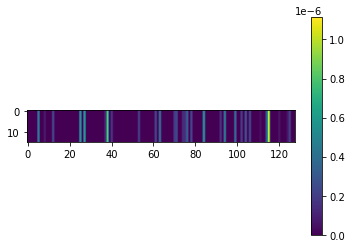

In [ ]:
# Apply guided backpropagation
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

print(guided_grads.shape)
guide_grads_example = guided_grads[:,100,:]
# print(guide_grads_example.shape)
guide_grads_example = np.squeeze(guide_grads_example, 0)
# plt.plot(np.squeeze(guide_grads_example, 0)) 
plt.show() 

guided_grads_image = [guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example]
plt.imshow(guided_grads_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

In [ ]:
guided_grads.shape

TensorShape([1, 115, 128])

min 0.0
max 3.2661185e-07


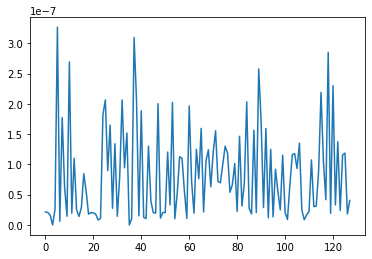

In [ ]:
weights = tf.reduce_mean(guided_grads, axis=(0,1))
#print("weights shape", weights.shape) 
print("min", np.min(weights))
print("max", np.max(weights))

plt.plot(weights) 
plt.show() 

#Weight of each filter in the conv layer 
# weights

min 0.0
max 3.2661185e-07


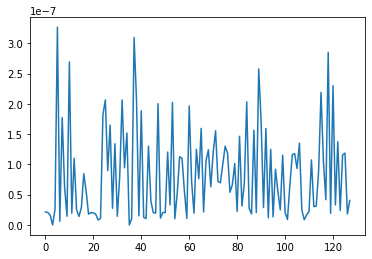

In [ ]:
weights = tf.reduce_mean(guided_grads, axis=(0,1))
#print("weights shape", weights.shape) 
print("min", np.min(weights))
print("max", np.max(weights))

plt.plot(weights) 
plt.show() 

#Weight of each filter in the conv layer 
# weights

min 1.0000016378602368
max 1.0000058845043895


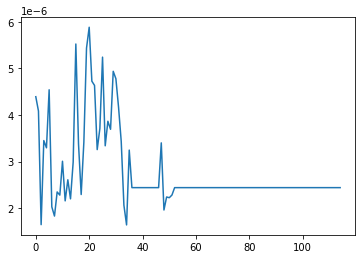

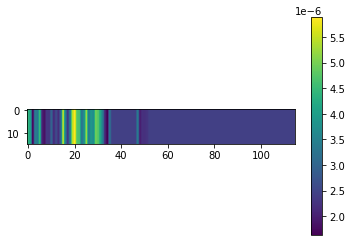

In [ ]:
cam = np.zeros(output.shape[0], dtype = np.float128)
cam
# print(cam.shape)
for i, w in enumerate(weights):
#     print(w)
    cam += w * output[:, i]
#     print(cam)
    
print("min", np.min(cam) + 1.0)
print("max", np.max(cam) + 1.0)

plt.plot(cam) 
plt.show() 

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

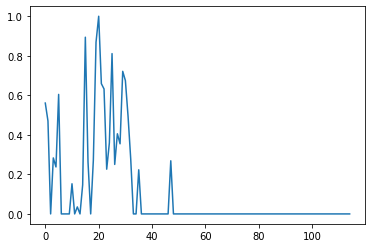

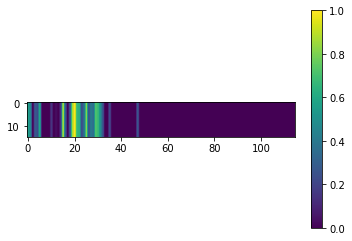

In [ ]:
cam = np.maximum(cam, 0.0)
cam = (cam - cam.min()) / (cam.max() - cam.min())
cam = np.maximum(cam, 0.2)
cam = (cam - cam.min()) / (cam.max() - cam.min())


plt.plot(cam) 
plt.show()

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) 
plt.colorbar()
plt.show()


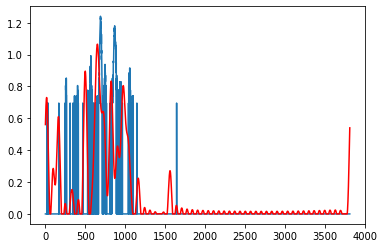

In [ ]:
from scipy import signal
f = signal.resample(cam, 3815)
f = np.maximum(f, 0.0)
plt.plot(a[0,:,0])
plt.plot(f, c = 'red')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:9116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


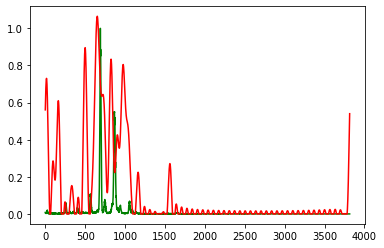

In [ ]:
row = tbl2.loc[IIDD,:]
row[row < 0] = 0
row = (row - np.min(row))/(np.max(row)-np.min(row))
row = np.expand_dims(row, axis = -1)

plt.plot(row, c = 'green')
plt.plot(f, c = 'red')

# Mistakes

In [ ]:
predicted = pd.DataFrame(data=result[:,:], index=y_test.index, columns=y_test.columns)  # 1st row as the column names

In [ ]:
y_test['Emerald green'] == result[:,2]

ID
4679     True
2805     True
1683     True
862      True
14444    True
         ... 
15494    True
10083    True
8183     True
14155    True
6339     True
Name: Emerald green, Length: 3245, dtype: bool

In [ ]:
cobalt_blue = y_test['Emerald green'] == result[:,2]

In [ ]:
temp = predicted[cobalt_blue == False]
temp
# temp[temp['Cobalt blue'] == True]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5561,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y_test[cobalt_blue == False]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0,0,0,0,0,0,0,1,1,0,0
7283,0,0,1,0,0,0,0,1,0,0,0
5561,0,0,1,0,0,1,0,0,0,0,0
9886,0,0,1,0,0,0,0,0,0,1,0
5562,0,0,1,0,0,1,0,0,0,0,0
5556,0,0,1,0,0,1,0,0,0,0,0
9864,0,0,1,0,0,0,0,0,0,1,0
3804,0,0,1,0,0,0,0,0,0,0,1
9875,0,0,1,0,0,0,0,0,0,1,0


# Plot Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm = multilabel_confusion_matrix(y_test, result)

In [ ]:
gt.columns

Index(['Cadmium yellow', 'Cobalt blue', 'Emerald green', 'Iron oxide',
       'Prussian blue', 'SnO1', 'Ultramarine blue', 'Vermilion', 'ZnO',
       'Chromate', 'Lead'],
      dtype='object')

In [ ]:
cm.shape

(11, 2, 2)

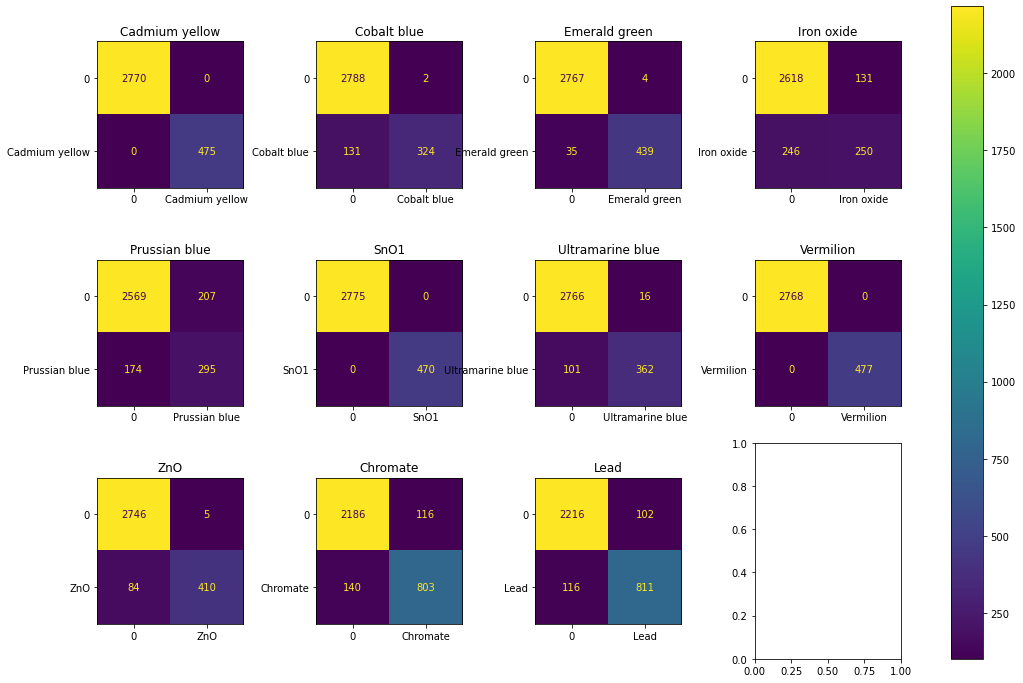

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()
for i in range(13):
    disp = ConfusionMatrixDisplay(cm[i,:,:],
                                  display_labels=[0, gt.columns[i]])
    disp.plot(ax=axes[i], values_format= '.4g')
    disp.ax_.set_title('{}'.format(gt.columns[i]))
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
#     disp.plot()

plt.subplots_adjust(wspace=0.5, hspace=0.01)
f.colorbar(disp.im_, ax = axes)
plt.show()